<a href="https://www.kaggle.com/code/clemwo/bitcoin-transactions-graph-neural-networks?scriptVersionId=194742250" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# !pip install networkx
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:00


In [2]:
# ---------------------- #
# General Kaggle imports #
# ---------------------- #

import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
import numpy as np
import pandas as pd        


# ------------------ #
# Additional imports #
# ------------------ #

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
from torch import Tensor
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning)

/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_features.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_classes.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv


<img src="https://www.bitcoinsistemi.com/wp-content/uploads/2023/12/bitcoin.jpg" alt="Bitcoin Graph Image" width="800"/>

# 💰Bitcoin Transactions 🔗 Graph Neural Networks 🪙

This notebook tackles [Kaggles Elliptic Bitcoin Transaction Dataset](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data) which maps Bitcoin transactions to real entities. In the description the objective for this dataset is described as:
> classifying the illicit and licit nodes in the graph.

[Wikipedia describes Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) as the first decentralized cryptocurrency. It also states that nodes in the Bitcoin network verify transactions through cryptography and record them in a public distributed ledger, called _blockchain_. The dataset we are going to work on in this notebook is an anonymized transaction graph collexted from such Bitcoin blockchain. Kaggles Data Card describes the dataset as having the following content: 

__Dataset Content__
- _Node_: represents a transaction. 
    - Each has 166 features
    - Labeled as ✅ _licit_, ❌ _illicit_ or 🤷 _unknown_
- _Edge_: represents a flow of Bitcoins between transaction `A` and transaction `B` 

Before we start, here are a couple concepts you should know for better understanding of the following code: 

| Concept | Math Notation | Description | More Information | 
| ------- | ------------- | ----------- | ---------------- |
| Graph | $G$ | Defined as pair $G=(V,E)$, where $V$ is a set of vertices and $E$ is a set of edges which are unordered pairs ${v_1, v_2}$ of vertices. | [Wikipedia: Graph (discrete mathematics)](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) | 
| Degree | $deg$ | Number of edges that are incident to a vertex. | [Wikipedia: Degree (graph theory)](https://en.wikipedia.org/wiki/Degree_(graph_theory)) | 
| Component | | Connected subgraph that is not part of any larger connected subgraph. | [Wikipedia: Component (graph theory](https://en.wikipedia.org/wiki/Component_(graph_theory)) | 

🚨 In the following notebook we will always call the graph $G$, the set of nodes $V$ and the set of edges $E$. 🚨

# Global Settings

In [3]:
RANDOM_STATE = 42

# Overview

Let's start by getting an overview of the datasets.

In [4]:
elliptic_txs_features = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
elliptic_txs_classes = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
elliptic_txs_edgelist = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols)
""")

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



__Nodes & Edges__

- $|V| = 203,768$ (number of nodes in $G$)
- $|E| = 234,355$ (number of edges in $G$)

In [5]:
elliptic_txs_features.head(3)  # Dataset containing the node features.

,txId,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792


In [6]:
elliptic_txs_classes.head(3)  # Dataset containing the classes of the node.

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown


In [7]:
elliptic_txs_edgelist.head(3)  # Dataset containing the edges.

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870


Let's get an overview on the distribution of the `class`es. 

In [8]:
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
class_counts = elliptic_txs_classes['class_mapped'].value_counts()

emoji_mapping = {'licit': '✅', 'illicit': '❌', 'unknown': '🤷'}
elliptic_txs_classes['emoji'] = elliptic_txs_classes['class_mapped'].map(emoji_mapping)

classes_df = pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),    
    'Counts': class_counts.values,
    'Percentage': percentage_distribution.values,
    'Emoji': [emoji_mapping[class_label] for class_label in elliptic_txs_classes['class_mapped'].unique()]
})
classes_df

,Class Mapped,Class Raw,Counts,Percentage,Emoji
0,unknown,unknown,157205,77.15,🤷
1,licit,2,42019,20.62,✅
2,illicit,1,4545,2.23,❌


- 77.15% of all classes are `unknown`
- 20.62% of all classes are `licit` (2)
- 2.23% of all classes are `illicit` (1)

In [9]:
# Sampling for easier analysis...for now.
classes_sampled = elliptic_txs_classes.groupby('class_mapped').sample(frac=0.05, random_state=RANDOM_STATE)
txIds_sampled = classes_sampled['txId']

# Filter elliptic_txs_edgelist based on the sampled txIds
edgelist_sampled = elliptic_txs_edgelist[
    elliptic_txs_edgelist['txId1'].isin(txIds_sampled) | elliptic_txs_edgelist['txId2'].isin(txIds_sampled)
]

# Filter elliptic_txs_features based on the sampled txIds
features_sampled = elliptic_txs_features[elliptic_txs_features['txId'].isin(txIds_sampled)]

print(f"Sampled Classes:\n{classes_sampled['class_mapped'].value_counts()}\n")
print(f"Sampled Edgelist: {edgelist_sampled.shape[0]:,}")
print(f"Sampled Features: {features_sampled.shape[0]:,}")

Sampled Classes:
class_mapped
unknown    7860
licit      2101
illicit     227
Name: count, dtype: int64

Sampled Edgelist: 23,051
Sampled Features: 10,188


# Exploratory Data Analysis (EDA) 

## Basic Statistics

Number of nodes: 10,188
Number of edges: 23,051


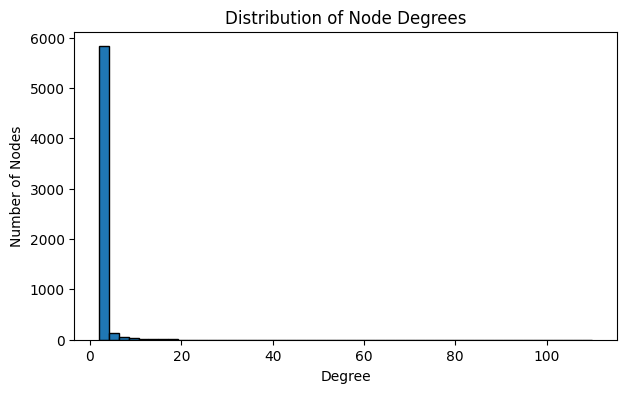

In [10]:
# Number of nodes and edges
num_nodes = features_sampled.shape[0]
num_edges = edgelist_sampled.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

# Distribution of node degrees
plt.figure(figsize=(7, 4))

node_degrees = edgelist_sampled['txId1'].value_counts() + edgelist_sampled['txId2'].value_counts()
node_degrees.hist(bins=50, edgecolor='black')
plt.title('Distribution of Node Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.grid(False)
plt.show()

## Graph Connectivity

In [11]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(edgelist_sampled, 'txId1', 'txId2')

Number of connected components: 7297
Giant component - Number of nodes: 400
Giant component - Number of edges: 431


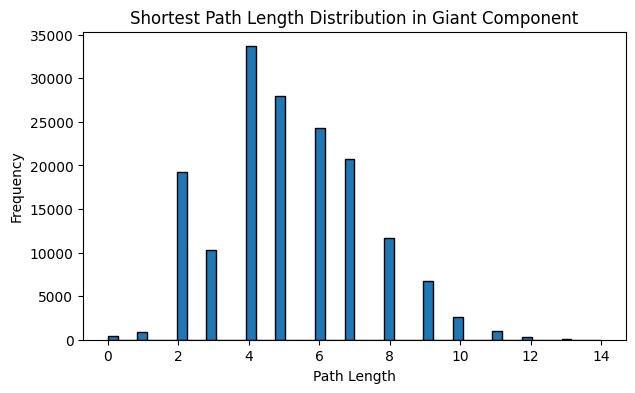

In [12]:
# --- Connected components ---
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

# --- Giant component analysis ---
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")


# --------------------------------------------------------- #
# Shortest paths length distribution in the giant component #
# --------------------------------------------------------- #
path_lengths = dict(nx.shortest_path_length(G_giant))
path_lengths_values = [length for target_lengths in path_lengths.values() for length in target_lengths.values()]

plt.figure(figsize=(7, 4))
plt.hist(path_lengths_values, bins=50, edgecolor='black')
plt.title('Shortest Path Length Distribution in Giant Component')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

## Node Centrality Measures

In this section we are going to investigate node centrality measures. Such measures are used in graph theory to identify the most important or influential nodes within a network. We will focus on the following three centrality measures: 

___🔢 Degree Centrality___

**Definition:**
Degree centrality measures the number of direct connections a node has in a network. It is defined as the number of edges connected to a node.

**Mathematical Function:**
$$
\begin{aligned}
& C_D(v) = \frac{\text{deg}(v)}{N - 1} \\ 
& \text{Where:} \\
& \qquad \text{deg}(v) \; \text{is the degree of node} \; (v) \; \text{(i.e., the number of edges connected to the node).} \\
& \qquad N \; \text{is the total number of nodes in the network.}
\end{aligned}
$$

**Interpretation:**
A node with a high degree centrality is highly connected and may play a crucial role in the network by having direct interactions with many other nodes.

___🔀 Betweenness Centrality___

**Definition:**
Betweenness centrality measures the extent to which a node lies on the shortest paths between other nodes in the network.

**Mathematical Function:**
$$
\begin{aligned}
& C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}} \\
& \text{Where:} \\
& \qquad \sigma_{st} \; \text{is the total number of shortest paths between nodes} \; (s) \; \text{and} \; (t). \\
& \qquad \sigma_{st}(v) \; \text{is the number of those paths that pass through node} \; (v).
\end{aligned}
$$

**Interpretation:**
A node with high betweenness centrality has significant control over the flow of information or resources in the network because it connects different parts of the network. It often indicates a node that is critical for communication.

___🌐 Closeness Centrality___

**Definition:**
Closeness centrality measures how close a node is to all other nodes in the network. It is the reciprocal of the sum of the shortest path distances from the node to all other nodes in the network.

**Mathematical Function:**
$$
\begin{aligned}
& C_C(v) = \frac{N-1}{\sum_{t \neq v} d(v, t)} \\
& \text{Where:} \\ 
& \qquad d(v, t) \; \text{is the shortest path distance between node} \; (v) \; \text{and node} \; (t). \\
& \qquad N \; \text{is the total number of nodes in the network.}
\end{aligned}
$$

**Interpretation:**
A node with high closeness centrality can quickly interact with all other nodes and can be an effective spreader of information or influence throughout the network.

---


Top 10 nodes by degree centrality:
        Node  Degree Centrality
0   22837965           0.275689
1   22837835           0.192982
2  279199578           0.030075
3    3807285           0.027569
4  279187194           0.027569
5   22837973           0.022556
6   90716926           0.022556
7    8128388           0.022556
8   22837808           0.020050
9   22838007           0.020050


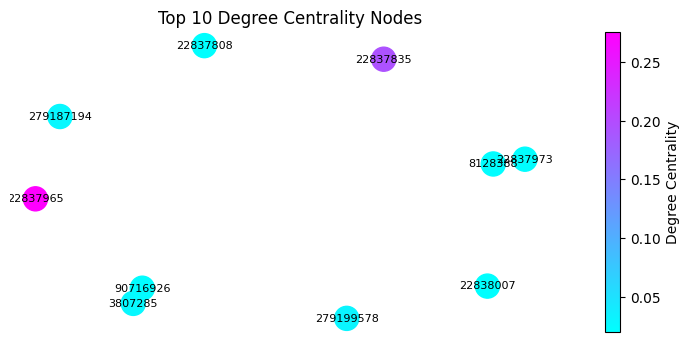

In [13]:
# Degree centrality.
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

print("Top 10 nodes by degree centrality:")
print("==================================")
print(df_top_degree_centrality)

top_nodes_by_ = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [degree_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)
plt.title('Top 10 Degree Centrality Nodes')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Degree Centrality')
plt.show()

Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0   22837835                0.553959
1   22837965                0.491607
2   90716926                0.166458
3   22837784                0.165590
4  279187194                0.164591
5    3807285                0.144993
6    3097782                0.113509
7    8128388                0.103709
8    1435388                0.092219
9   21296808                0.086872


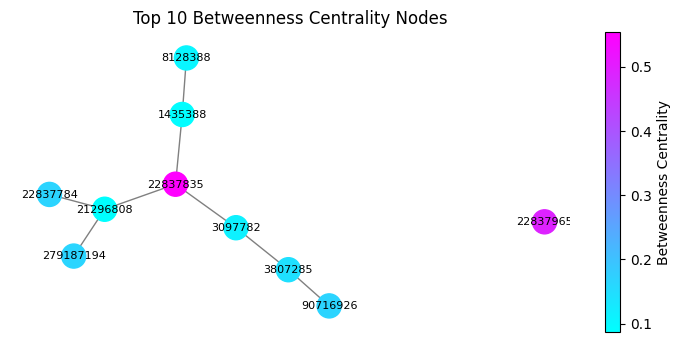

In [14]:
# Betweenness centrality.
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("Top 10 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness_centrality)

top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)
plt.title('Top 10 Betweenness Centrality Nodes')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Betweenness Centrality')
plt.show()

Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0   22837835              0.317928
1   22837965              0.293814
2    2203811              0.290605
3    1805107              0.285817
4   11447640              0.285817
5    2205152              0.285817
6    1367537              0.285817
7    1437191              0.285817
8   21296808              0.274038
9  279187194              0.271613


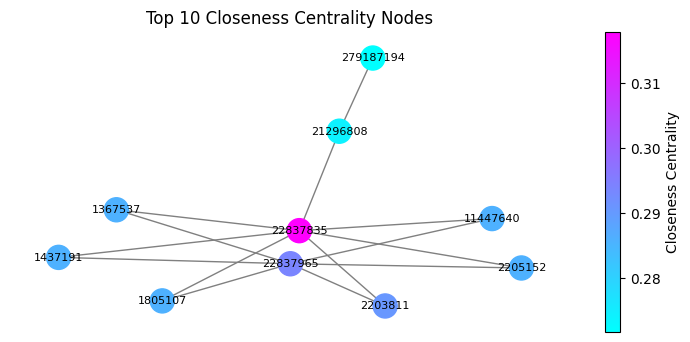

In [15]:
# Closeness centrality.
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 10 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)
node_color = [closeness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)
plt.title('Top 10 Closeness Centrality Nodes')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Closeness Centrality')
plt.show()

## Graph Visualization

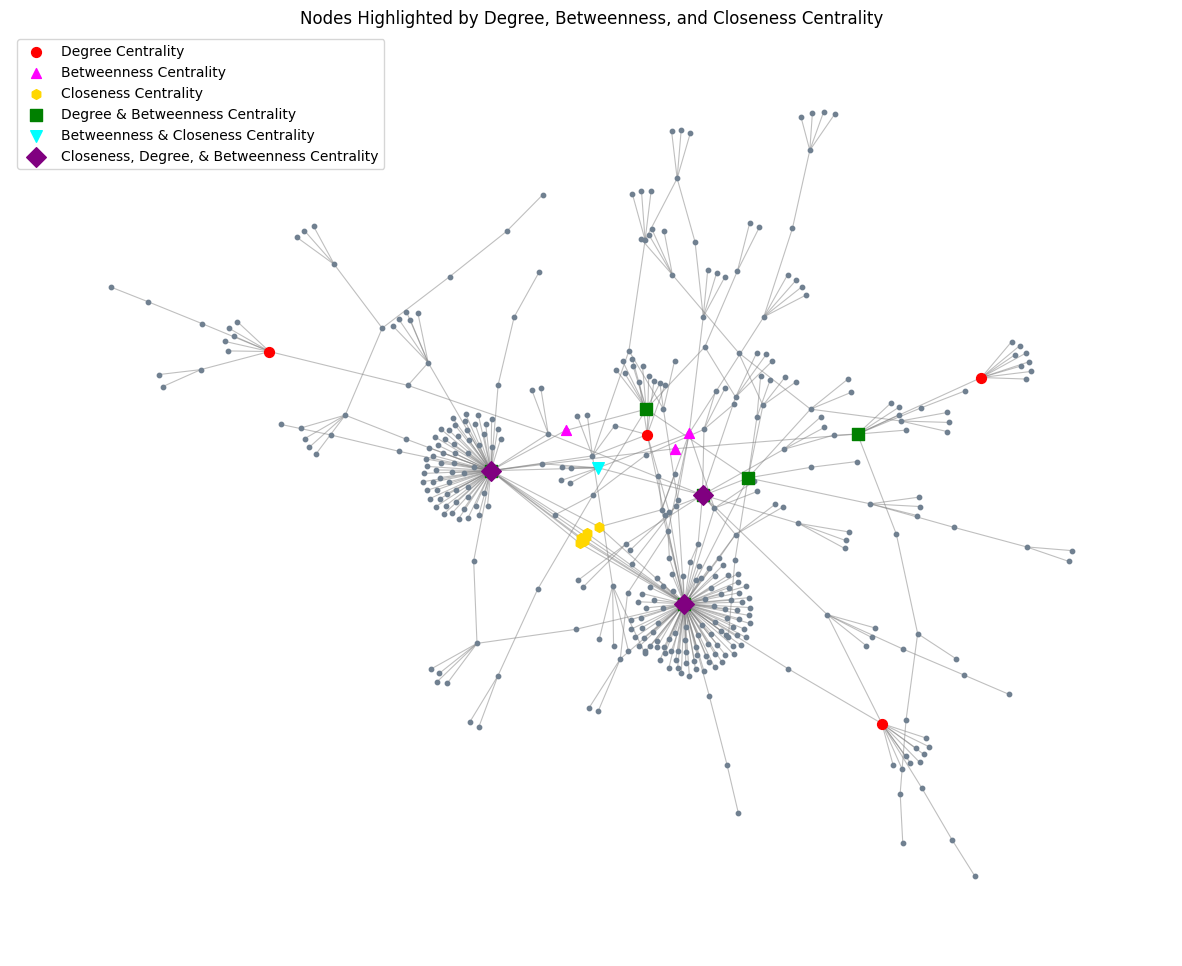

In [16]:
# --------- #
# Preparing #
# --------- #

# Identify nodes that are top in each centrality measure and their combinations.
top_nodes_degree = set([node for node, _ in top_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness_centrality])
top_nodes_closeness = set([node for node, _ in top_closeness_centrality])

top_nodes_both = top_nodes_degree.intersection(top_nodes_betweenness)
top_nodes_closeness_and_degree = top_nodes_closeness.intersection(top_nodes_degree)
top_nodes_closeness_and_betweenness = top_nodes_closeness.intersection(top_nodes_betweenness)
top_nodes_all_three = top_nodes_closeness.intersection(top_nodes_degree).intersection(top_nodes_betweenness)

# Assign colors and shapes based on centrality measures.
node_color = []
node_shape = []

for node in G_giant.nodes():
    if node in top_nodes_all_three:
        node_color.append('purple')
        node_shape.append('D')
    elif node in top_nodes_closeness_and_degree and node in top_nodes_closeness_and_betweenness:
        node_color.append('blue')
        node_shape.append('p')
    elif node in top_nodes_both:
        node_color.append('green')
        node_shape.append('s')
    elif node in top_nodes_closeness_and_degree:
        node_color.append('orange')
        node_shape.append('h')
    elif node in top_nodes_closeness_and_betweenness:
        node_color.append('cyan')
        node_shape.append('v')
    elif node in top_nodes_degree:
        node_color.append('red')
        node_shape.append('o')
    elif node in top_nodes_betweenness:
        node_color.append('magenta')
        node_shape.append('^')
    elif node in top_nodes_closeness:
        node_color.append('yellow')
        node_shape.append('h')
    else:
        node_color.append('slategrey')
        node_shape.append('o')

# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(15, 12))

pos = nx.spring_layout(G_giant)
# Draw all nodes first.
nx.draw_networkx_nodes(G_giant, pos, node_color='slategrey', node_size=10)

# Draw nodes with specific centrality measures.
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_degree - top_nodes_both - top_nodes_closeness_and_degree), 
                       node_color='red', node_size=50, node_shape='o', 
                       label='Degree Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_betweenness - top_nodes_both - top_nodes_closeness_and_betweenness), 
                       node_color='magenta', node_size=50, node_shape='^', 
                       label='Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness), 
                       node_color='gold', node_size=50, node_shape='h', 
                       label='Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_both), 
                       node_color='green', node_size=80, node_shape='s', 
                       label='Degree & Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_degree - top_nodes_all_three), 
                       node_color='orange', node_size=70, node_shape='h', 
                       label='Degree & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_betweenness - top_nodes_all_three), 
                       node_color='cyan', node_size=70, node_shape='v', 
                       label='Betweenness & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_all_three), 
                       node_color='purple', node_size=100, node_shape='D', 
                       label='Closeness, Degree, & Betweenness Centrality')

# Draw edges.
nx.draw_networkx_edges(G_giant, pos, width=0.8, edge_color='gray', alpha=0.5)

plt.axis('off')
plt.title('Nodes Highlighted by Degree, Betweenness, and Closeness Centrality')
plt.legend(scatterpoints=1)
plt.show()

## Class-specific Analysis

In [17]:
# Class-based subgraphs.
illicit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'illicit']['txId']
licit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'licit']['txId']

G_illicit = G.subgraph(illicit_nodes)
G_licit = G.subgraph(licit_nodes)

In [18]:
classes_df

,Class Mapped,Class Raw,Counts,Percentage,Emoji
0,unknown,unknown,157205,77.15,🤷
1,licit,2,42019,20.62,✅
2,illicit,1,4545,2.23,❌


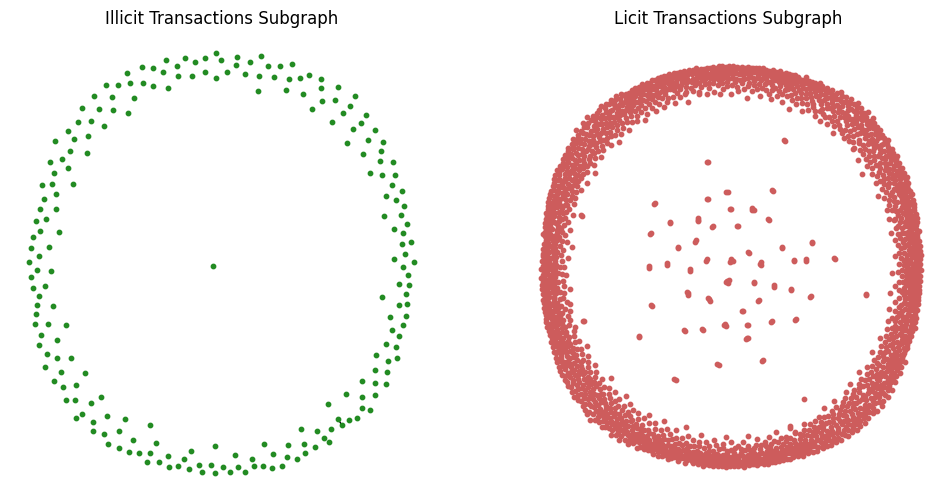

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(G_illicit, with_labels=False, node_size=10, node_color='forestgreen', edge_color='black')
plt.title('Illicit Transactions Subgraph')

plt.subplot(1, 2, 2)
nx.draw(G_licit, with_labels=False, node_size=10, node_color='indianred', edge_color='black')
plt.title('Licit Transactions Subgraph')

plt.show()

# Graph Neural Networks 

Work in Progress...

---


💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏